In [ ]:
!nvidia-smi

Sat Jun 13 11:29:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    39W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Для начала я решил попробовать решить типичную для сайклгана задачу перекрашивания зебр и лошадей

In [ ]:
! wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

--2020-06-13 11:08:49--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  21.3MB/s    in 6.2s    

2020-06-13 11:08:57 (17.9 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



In [ ]:
!unzip /content/horse2zebra.zip

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

class MakeDataset(Dataset): # Подготовка датасета

    def __init__(self, files, files1 = None, mode = None, mode_sample = None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        self.len_ = len(self.files)
        self.mode = mode
        if self.mode == None:
            self.files1 = sorted(files1)
            self.len1_ = len(self.files1)
        self.mode_sample = mode_sample
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])
        x = self.load_sample(self.files[index % len(self.files)])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == None:
            if self.mode_sample == 'rand':
                y = self.load_sample(self.files1[random.randint(0, len(self.files1) - 1)])
            else:
                y = self.load_sample(self.files1[index % len(self.files)])
            y = self._prepare_sample(y)
            y = np.array(y / 255, dtype='float32')
            y = transform(y)

            return x, y
        else:
            return x
        
    def _prepare_sample(self, image):
        image = image.resize((256, 256))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False): # Функция вывода изображения

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array((0.5,0.5,0.5))
    std = np.array((0.5,0.5,0.5))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
train_horse = Path('/content/horse2zebra/trainA')
train_zebra = Path('/content/horse2zebra/trainB')

zebra_files = sorted(list(train_zebra.rglob('*.jpg')))
horse_files = sorted(list(train_horse.rglob('*.jpg')))

In [ ]:
zebras = []
horses = []
for filename in zebra_files:
  zebras.append(str(filename))

for filename in horse_files:
  horses.append(str(filename)) 

In [ ]:
len(horses)

1067

In [ ]:
len(zebras) # Мы видим, что размер выборок разный. 

1334

In [ ]:
def prov(file): # В датасете есть чёрно-белые картинки, поэтому отбрасываем их
  transform = transforms.ToTensor()
  image = Image.open(file)
  image.load()
  image = np.array(image.resize((256, 256)))
  image = np.array(image / 255, dtype='float32')
  image = transform(image)
  return image

In [ ]:
new_zebra = []

for file in zebra_files:
  if len(prov(file)) == 3:
    new_zebra.append(file)

In [ ]:
len(new_zebra) 

1327

In [ ]:
import torch

num = torch.randint(0, len(horses), ((len(new_zebra) - len(horses),))) # Пусть размеры сетов зебр и лошадей будет одинаковыми
for i in num:
  horses.append(horses[i])

In [ ]:
len(horses)

1327

In [ ]:
train_dataset = MakeDataset(horses, new_zebra)

In [ ]:
len(train_dataset)

1327

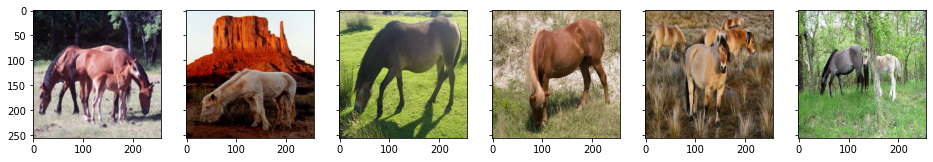

In [ ]:
import random
fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val = train_dataset[random_characters][0]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

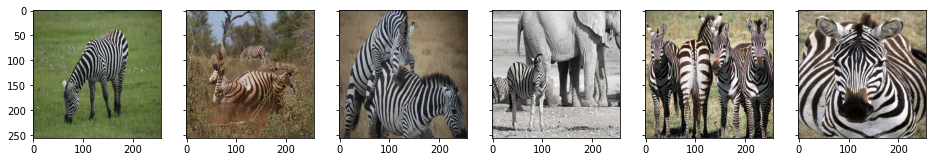

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val = train_dataset[random_characters][1]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

In [ ]:
test_horse = Path('/content/horse2zebra/testA')
test_zebra = Path('/content/horse2zebra/testB')

zebra_test_files = sorted(list(test_zebra.rglob('*.jpg')))
horse_test_files = sorted(list(test_horse.rglob('*.jpg')))

In [ ]:
len(zebra_test_files)

140

In [ ]:
len(horse_test_files)

120

In [ ]:
zebras_test = []
horses_test = []
for filename in zebra_test_files:
  zebras_test.append(str(filename))

for filename in horse_test_files:
  horses_test.append(str(filename)) 

num = torch.randint(0, len(horses_test), ((len(zebras_test) - len(horses_test),)))
for i in num:
  horses_test.append(horses[i])

In [ ]:
len(horses_test)

140

In [ ]:
test_dataset = MakeDataset(horses_test, zebras_test, mode = None)

Модель

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class discriminator(nn.Module):  # Для дискриминатора я выбрал архитектуру PatchGAN
  def __init__(self):
    super(discriminator, self).__init__()
    self.conv_0 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1), 
    nn.InstanceNorm2d(64), 
    nn.LeakyReLU(0.2, inplace=True)) 
    self.conv_1 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), 
    nn.InstanceNorm2d(128), 
    nn.LeakyReLU(0.2, inplace=True)) 
    self.conv_2 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), 
    nn.InstanceNorm2d(256), 
    nn.LeakyReLU(0.2, inplace=True)) 
    self.conv_3 = nn.Sequential(nn.Conv2d(256, 512, 4, 1, 1), 
    nn.InstanceNorm2d(512), 
    nn.LeakyReLU(0.2, inplace=True)) 
    self.conv_4 = nn.Sequential(nn.Conv2d(512, 1, 4, 1, 1)) 
  
  def forward(self, x):
    c1 = self.conv_0(x)
    c2 = self.conv_1(c1)
    c3 = self.conv_2(c2)
    c4 = self.conv_3(c3)
    c5 = self.conv_4(c4)  
    return F.avg_pool2d(c5, c5.size()[2:]).view(c5.size()[0], -1)

class generator(nn.Module): # В качестве генератора будет энкодер, bottleneck с 9 блоками и декодер
  def __init__(self):
    super(generator, self).__init__()
   
    self.conv_0 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 7, stride = 1, padding = 3), # 256 -> 128
    nn.InstanceNorm2d(64), 
    nn.ReLU(inplace=True)) 
    self.conv_1 = nn.Sequential(nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1), 
    nn.InstanceNorm2d(128), 
    nn.ReLU(inplace=True)) 
    self.conv_2 = nn.Sequential(nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1), 
    nn.InstanceNorm2d(256), 
    nn.ReLU(inplace=True)) 

    # Residual 
    self.resconv_0 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1), 
    nn.InstanceNorm2d(256), 
    nn.ReLU(inplace=True)) 
    self.resconv_1 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1), 
    nn.InstanceNorm2d(256), 
    nn.ReLU(inplace=True)) 
    self.resconv_2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1), 
    nn.InstanceNorm2d(256), 
    nn.ReLU(inplace=True)) 
    self.resconv_3 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1), 
    nn.InstanceNorm2d(256), 
    nn.ReLU(inplace=True)) 
    self.resconv_4 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1), 
    nn.InstanceNorm2d(256), 
    nn.ReLU(inplace=True)) 
    self.resconv_5 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1), 
    nn.InstanceNorm2d(256), 
    nn.ReLU(inplace=True)) 
    self.resconv_6 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1), 
    nn.InstanceNorm2d(256), 
    nn.ReLU(inplace=True)) 
    self.resconv_7 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1), 
    nn.InstanceNorm2d(256), 
    nn.ReLU(inplace=True)) 
    self.resconv_8 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1), 
    nn.InstanceNorm2d(256), 
    nn.ReLU(inplace=True)) 

    # decoder
    self.deconv_0 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1), 
    nn.InstanceNorm2d(128), 
    nn.ReLU(inplace=True)) 
    self.deconv_1 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1), 
    nn.InstanceNorm2d(64), 
    nn.ReLU(inplace=True)) 
    self.deconv_2 = nn.Sequential(nn.ConvTranspose2d(64, 3, kernel_size = 7, stride = 1, padding = 3), 
    nn.Tanh()) # Тангенс в конце для нормализации выхода от -1 до 1
  
  def forward(self, x):
    c1 = self.conv_0(x)
    c2 = self.conv_1(c1)
    c3 = self.conv_2(c2)

    r1 = self.resconv_0(c3)
    r2 = self.resconv_1(r1)
    r3 = self.resconv_2(r2)
    r4 = self.resconv_3(r3)
    r5 = self.resconv_4(r4)
    r6 = self.resconv_5(r5)
    r7 = self.resconv_6(r6)
    r8 = self.resconv_7(r7)
    r9 = self.resconv_8(r8)

    d1 = self.deconv_0(r9)
    d2 = self.deconv_1(d1)
    d3 = self.deconv_2(d2)
    return d3


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
netG_A2B = generator().to(device)
netG_B2A = generator().to(device)
netD_A = discriminator().to(device)
netD_B = discriminator().to(device)


In [ ]:
num_epochs = 200

In [ ]:
class ReplayBuffer(): # Так же для более оптимального обучения дискриминатора я добавил pool (в размере 50), благодаря которому он будет обучаться не только на последних предсказаниях, но и на некоторой части предыдущих
    def __init__(self, max_size=50):
        
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


In [ ]:
Tensor = torch.cuda.FloatTensor 

In [ ]:
from torch.autograd import Variable

batch_size = 12

target_real = Variable(torch.ones(batch_size).to(device), requires_grad=False)
target_fake = Variable(torch.zeros(batch_size).to(device), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()


In [ ]:
def weights_init_normal(m): # Функция инициализации весов
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [ ]:
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.


discriminator(
  (conv_0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0

In [ ]:
def for_show(inp, mode = 'numpy'): # Для вывода картинок во время трейна
  if mode != 'numpy':
    inp = inp.numpy().transpose((1, 2, 0))
  else:
    inp = inp.transpose((1, 2, 0))
  mean = np.array((0.5,0.5,0.5))
  std = np.array((0.5,0.5,0.5))
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  return inp

In [ ]:
import itertools
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train(train_dataset, netG_A2B, netG_B2A, netD_A, netD_B, epochs = 200, batch_size = 4):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    history = []
    log_template = "\nEpoch {ep:03d} loss_G: {loss_G:0.4f} \
    loss_G_identity {loss_G_identity:0.4f} loss_G_GAN {loss_G_GAN:0.4f} loss_G_cycle {loss_G_cycle:0.4f} loss_D {loss_D:0.4f}"

    with tqdm(desc="epoch", total = epochs) as pbar_outer:
      criterion_GAN = torch.nn.MSELoss()
      criterion_cycle = torch.nn.L1Loss()
      criterion_identity = torch.nn.L1Loss()
      
      optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
      optimizer_D = torch.optim.Adam(itertools.chain(netD_A.parameters(), netD_B.parameters()), lr=0.0002, betas=(0.5, 0.999))


      lr_scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=100, gamma=0.01)
      lr_scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=100, gamma=0.01)
  
    for epoch in range(epochs):
          i = 0
          for A, B in train_loader:

            real_A = Variable(A).to(device)
            real_B = Variable(B).to(device)
            
            ### ГЕНЕРАТОРЫ ###
            optimizer_G.zero_grad()
            
            # Identity loss
            same_B = netG_A2B(real_B)
            loss_identity_B = criterion_identity(same_B, real_B)*5.0
            same_A = netG_B2A(real_A)
            loss_identity_A = criterion_identity(same_A, real_A)*5.0
            
            # GAN loss
            fake_B = netG_A2B(real_A)
            pred_fake = netD_B(fake_B)
            loss_GAN_A2B = criterion_GAN(pred_fake, target_real)
            fake_A = netG_B2A(real_B)
            pred_fake = netD_A(fake_A)
            loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

            # Cycle loss
            recovered_A = netG_B2A(fake_B)
            loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0
            recovered_B = netG_A2B(fake_A)
            loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

            # Общий loss
            loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
            loss_G.backward()       

            optimizer_G.step()


            ### ДИСКРИМИНАТОРЫ ###
            optimizer_D.zero_grad()

            # Real loss
            pred_real_A = netD_A(real_A)
            loss_D_real_A = criterion_GAN(pred_real_A, target_real)
            
            pred_real_B = netD_B(real_B)
            loss_D_real_B = criterion_GAN(pred_real_B, target_real)


            # Fake loss
            fake_A = fake_A_buffer.push_and_pop(fake_A)
            pred_fake_A = netD_A(fake_A.detach())
            loss_D_fake_A = criterion_GAN(pred_fake_A, target_fake)
            
            fake_B = fake_B_buffer.push_and_pop(fake_B)
            pred_fake_B = netD_B(fake_B.detach())
            loss_D_fake_B = criterion_GAN(pred_fake_B, target_fake)

            
            # Общий loss
            loss_D = (loss_D_real_A + loss_D_fake_A + loss_D_real_B + loss_D_fake_B)*0.5
            loss_D.backward()

            optimizer_D.step()

            i+=1
            print(i) # Для подробного контролирования процесса, я выводил номер прогнанного батча

          lr_scheduler_G.step()
          lr_scheduler_D.step()
          
          netG_A2B.eval() 
          netG_B2A.eval() 
          netD_A.eval()
          netD_B.eval()
          with torch.no_grad():
              if epoch % 10 == 0: # Будем сохранять веса каждые 10 эпох
                torch.save(netG_A2B.state_dict(), 'drive/My Drive/Models/netG_A2B(%d).pth' % (epoch))
                torch.save(netG_B2A.state_dict(), 'drive/My Drive/Models/netG_B2A(%d).pth' % (epoch))
                torch.save(netD_A.state_dict(), 'drive/My Drive/Models/netD_A(%d).pth' % (epoch))
                torch.save(netD_B.state_dict(), 'drive/My Drive/Models/netD_B(%d).pth' % (epoch))
              
              ## ВЫВОД ##
              clear_output(wait=True)
              fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(20, 20), \
                        sharey=True, sharex=True)
              
              real_A, real_B = next(iter(train_loader))
              real_A = Variable(real_A).to(device)
              real_B = Variable(real_B).to(device)
              
              fake_B = netG_A2B(real_A) 
              recovered_A = netG_B2A(fake_B)
              recovered_A = recovered_A.detach().to('cpu').numpy()
              fake_B = fake_B.detach().to('cpu').numpy()
              real_A = real_A.detach().to('cpu').numpy()

              fake_A = netG_B2A(real_B) 
              recovered_B = netG_A2B(fake_A)
              recovered_B = recovered_B.detach().to('cpu').numpy()
              fake_A = fake_A.detach().to('cpu').numpy()
              real_B = real_B.detach().to('cpu').numpy()

              plt.subplot(2, 3, 1)
              plt.imshow(for_show(real_A[0]))
              plt.title('Real_A')
              plt.axis('off')

              plt.subplot(2, 3, 2)
              plt.imshow(for_show(fake_B[0]))
              plt.title('fake_B')
              plt.axis('off')

              plt.subplot(2, 3, 3)
              plt.imshow(for_show(recovered_A[0]))
              plt.title('recovered_A')
              plt.axis('off')

              plt.subplot(2, 3, 4)
              plt.imshow(for_show(real_B[0]))
              plt.title('Real_B')
              plt.axis('off')

              plt.subplot(2, 3, 5)
              plt.imshow(for_show(fake_A[0]))
              plt.title('fake_A')
              plt.axis('off')

              plt.subplot(2, 3, 6)
              plt.imshow(for_show(recovered_B[0]))
              plt.title('recovered_B')
              plt.axis('off')
              plt.suptitle('%d / %d - loss_G: %f,     loss_D: %f' % (epoch+1, epochs, loss_G, loss_D))
              plt.show()
         
          history.append((loss_G, (loss_identity_A + loss_identity_B), (loss_GAN_A2B + loss_GAN_B2A), (loss_cycle_ABA + loss_cycle_BAB), loss_D))
            
          pbar_outer.update(1)
          tqdm.write(log_template.format(ep=epoch+1, loss_G=loss_G,\
                                           loss_G_identity=(loss_identity_A + loss_identity_B), loss_G_GAN=(loss_GAN_A2B + loss_GAN_B2A), loss_G_cycle = (loss_cycle_ABA + loss_cycle_BAB), loss_D = loss_D))
            
    return history

In [ ]:
import gc # Освободим лишнюю память перед обучением
gc.collect()

35662

In [ ]:
history = train(train_dataset, netG_A2B, netG_B2A, netD_A, netD_B, epochs = 200, batch_size = batch_size)

Теперь после обучения проверим нашу модель

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
fake_A = []
fake_B = []
i = 0
for A, B in test_loader:
    if i < 6:
        fake_A.append(netG_A2B(A.to(device)))
        fake_B.append(netG_B2A(B.to(device)))
    i+=1

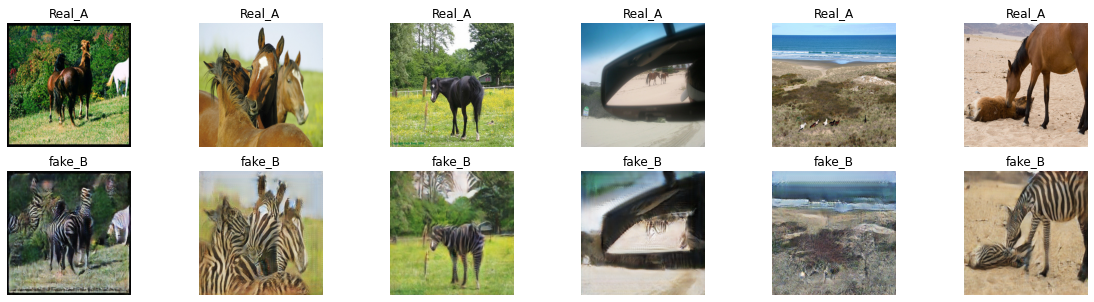

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(20, 5), \
                        sharey=True, sharex=True)
for k in range(6):              
              plt.subplot(2, 6, k+1)
              plt.imshow(for_show(test_dataset[k][0], None))
              plt.title('Real_A')
              plt.axis('off')

              plt.subplot(2, 6, k+7)
              plt.imshow(for_show(fake_A[k][0].detach().cpu(), None))
              plt.title('fake_B')
              plt.axis('off')

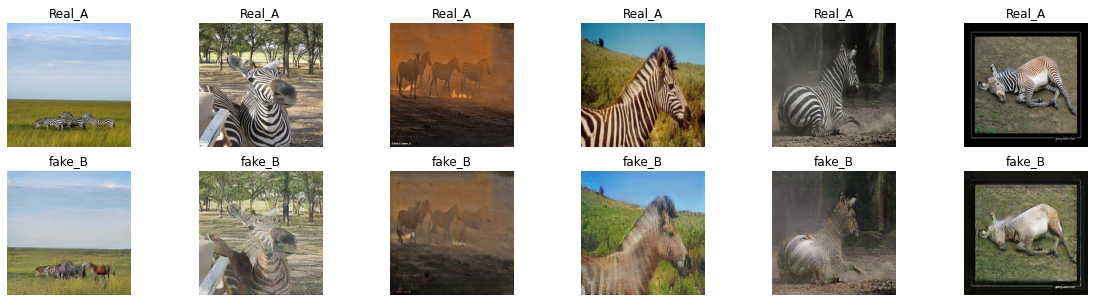

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(20, 5), \
                        sharey=True, sharex=True)
for k in range(6):              
              plt.subplot(2, 6, k+1)
              plt.imshow(for_show(test_dataset[k][1], None))
              plt.title('Real_A')
              plt.axis('off')

              plt.subplot(2, 6, k+7)
              plt.imshow(for_show(fake_B[k][0].detach().cpu(), None))
              plt.title('fake_B')
              plt.axis('off')

**Мы видим, что модель показывает хорошие результаты после 200 эпох, а значит теперь можно реализовывать свою задачу**

Я попробовал превращать азиатских мужчин в европейских и наоборот, и вот что из этого получилось

In [ ]:
!unzip Asian.zip
!unzip European.zip

Датасет я собрал сам с помощью Яндекс.картинок и чуть-чуть отфильтровал их, убрав неудачные фотографии

In [ ]:
train_as = Path('/content/Asian')
train_eu = Path('/content/European')

as_files = sorted(list(train_as.rglob('*.jpeg')))
eu_files = sorted(list(train_eu.rglob('*.jpeg')))

In [ ]:
asian = []
european = []
for filename in as_files:
  asian.append(str(filename))

for filename in eu_files:
  european.append(str(filename)) 

In [ ]:
len(asian)

702

In [ ]:
len(european)

847

In [ ]:
new_asian = []
new_european = []
for file in asian:
  if len(prov(file)) == 3:
    new_asian.append(file)

for file in european:
  if len(prov(file)) == 3:
    new_european.append(file)

In [ ]:
import torch

num = torch.randint(0, len(new_asian), ((len(new_european) - len(new_asian),))) 
for i in num:
  new_asian.append(new_asian[i])

In [ ]:
len(new_asian)

847

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     new_asian, new_european, test_size=0.01, random_state=42)


In [ ]:
train_dataset = MakeDataset(X_train, y_train)
test_dataset = MakeDataset(X_test, y_test, mode = None)

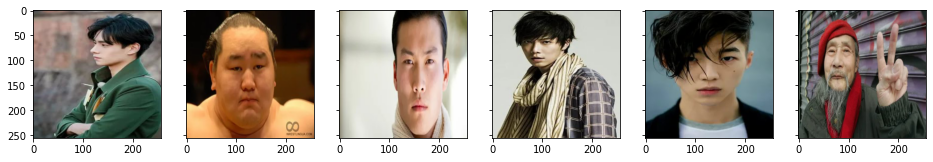

In [ ]:
import random
fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val = train_dataset[random_characters][0]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

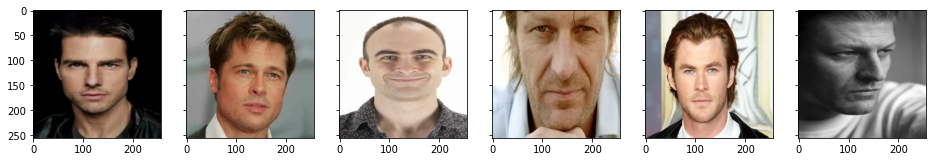

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val = train_dataset[random_characters][1]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

Проделываем с датой те же манипуляции, что и с horse2zebra и начинаем тренировать модель

In [ ]:
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.


discriminator(
  (conv_0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0

In [ ]:
import gc
gc.collect()

15

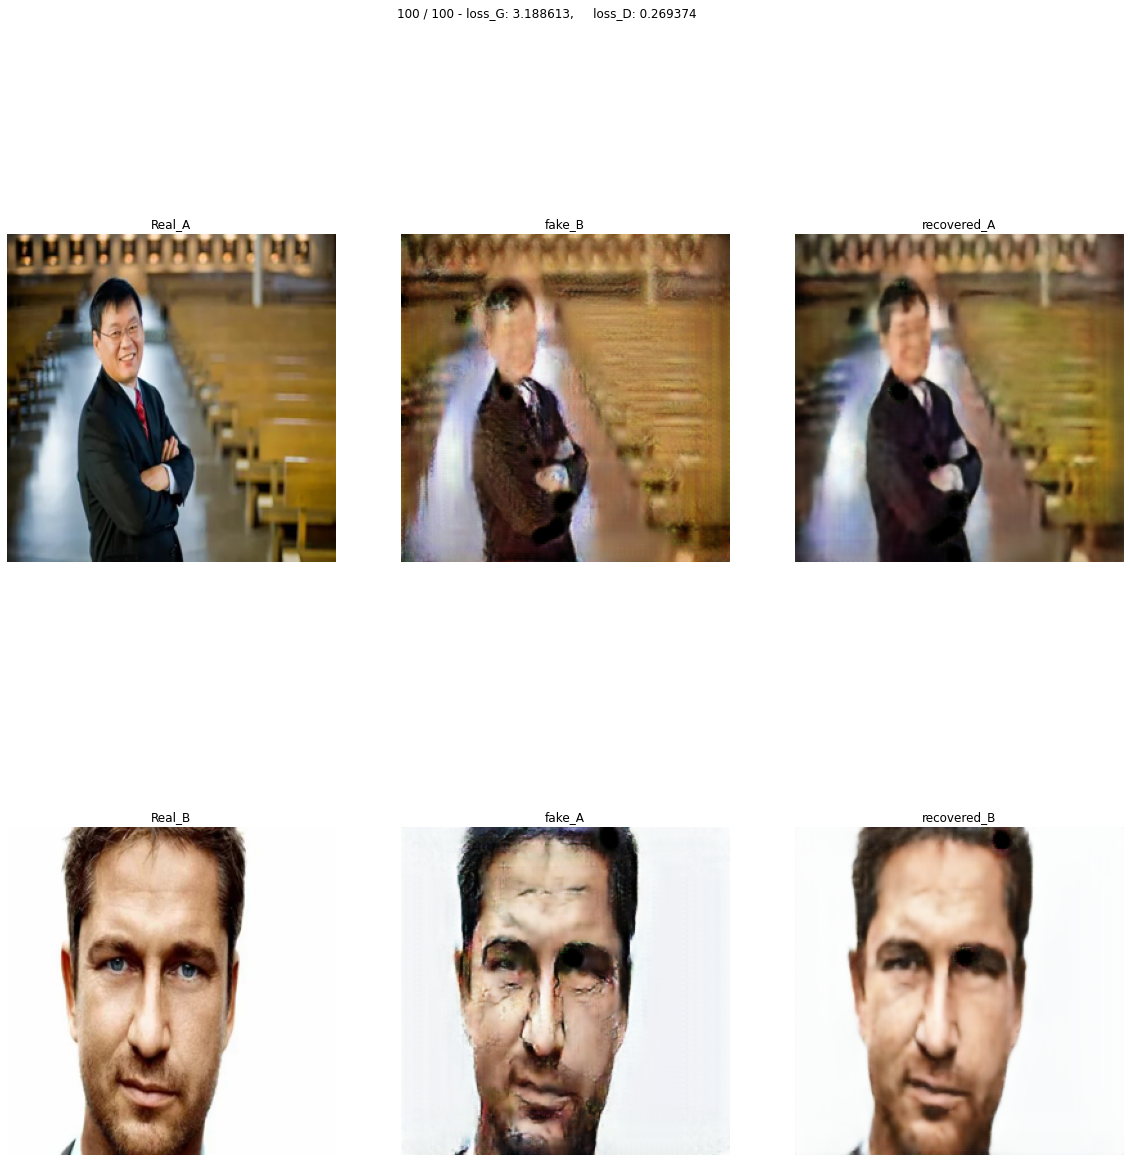


Epoch 100 loss_G: 3.1886     loss_G_identity 0.6493 loss_G_GAN 1.0473 loss_G_cycle 1.4920 loss_D 0.2694


In [ ]:
history = train(train_dataset, netG_A2B, netG_B2A, netD_A, netD_B, epochs = num_epochs, batch_size = batch_size)

К сожалению, из-за нужды огромной памяти и времени не удалось прогнать все 200 эпох сразу

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
fake_A = []
fake_B = []
i = 0
for A, B in test_loader:
    if i < 6:
        fake_A.append(netG_A2B(A.to(device)))
        fake_B.append(netG_B2A(B.to(device)))
    i+=1

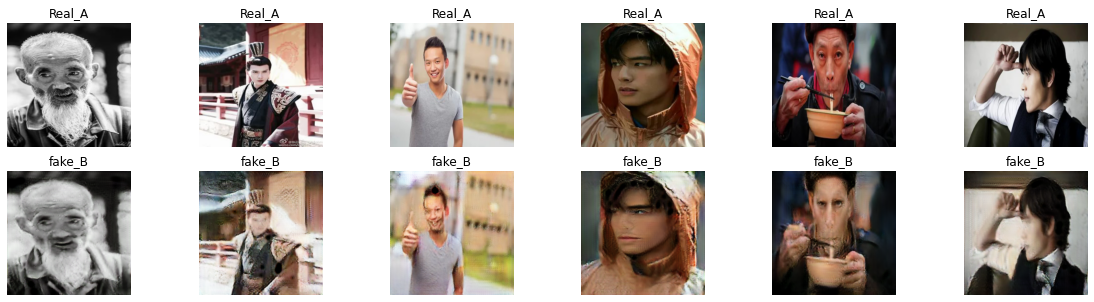

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(20, 5), \
                        sharey=True, sharex=True)
for k in range(6):              
              plt.subplot(2, 6, k+1)
              plt.imshow(for_show(test_dataset[k][0], None))
              plt.title('Real_A')
              plt.axis('off')

              plt.subplot(2, 6, k+7)
              plt.imshow(for_show(fake_A[k][0].detach().cpu(), None))
              plt.title('fake_B')
              plt.axis('off')

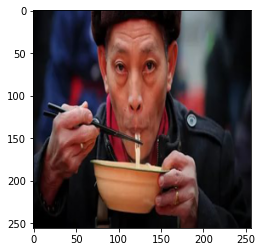

In [ ]:
imshow(test_dataset[4][0])

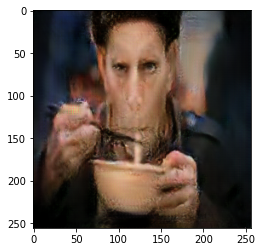

In [ ]:
imshow(fake_A[4][0].detach().cpu())

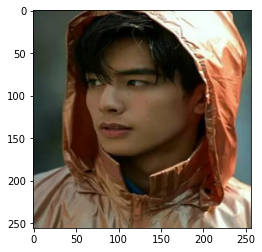

In [ ]:
imshow(test_dataset[3][0])

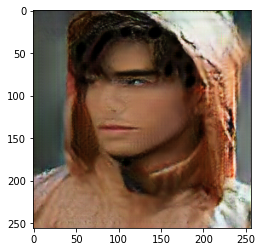

In [ ]:
imshow(fake_A[3][0].detach().cpu())

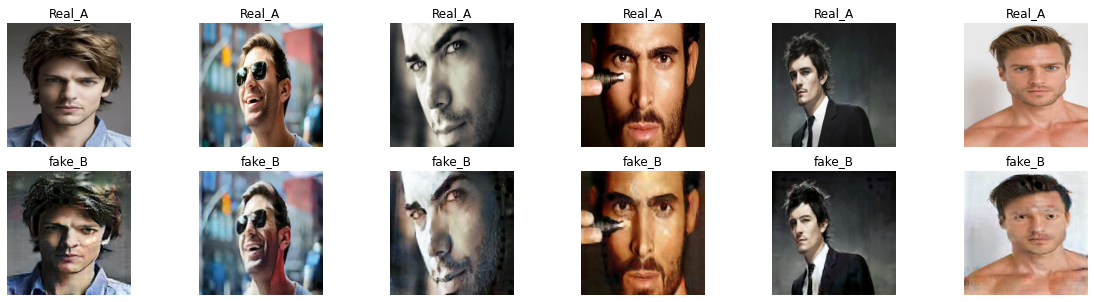

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(20, 5), \
                        sharey=True, sharex=True)
for k in range(6):              
              plt.subplot(2, 6, k+1)
              plt.imshow(for_show(test_dataset[k][1], None))
              plt.title('Real_A')
              plt.axis('off')

              plt.subplot(2, 6, k+7)
              plt.imshow(for_show(fake_B[k][0].detach().cpu(), None))
              plt.title('fake_B')
              plt.axis('off')

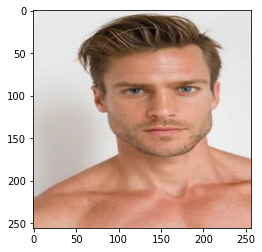

In [ ]:
imshow(test_dataset[5][1])

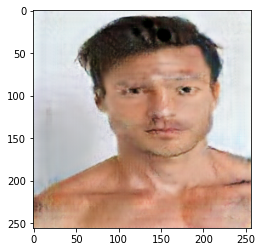

In [ ]:
imshow(fake_B[5][0].detach().cpu())

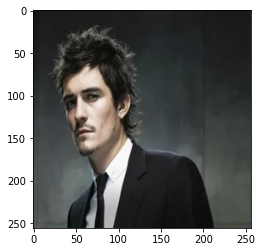

In [ ]:
imshow(test_dataset[4][1])

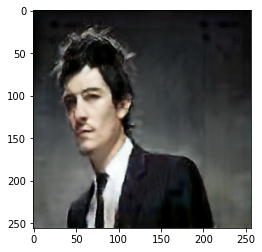

In [ ]:
imshow(fake_B[4][0].detach().cpu())

Мы видим, что модель достаточно правильно научилась менять цвет кожи, волос, разрез глаз и губы, но плохо работает на лицах вблизи и на тестовой части результаты оказались чуть-чуть хуже, чем на трейновом

In [ ]:
train_loaderr = DataLoader(train_dataset, batch_size=1, shuffle=False)

fake_A_train = []
fake_B_train = []
i = 0
for A, B in train_loaderr:
    if i < 6:
        fake_A_train.append(netG_A2B(A.to(device)))
        fake_B_train.append(netG_B2A(B.to(device)))
    i+=1



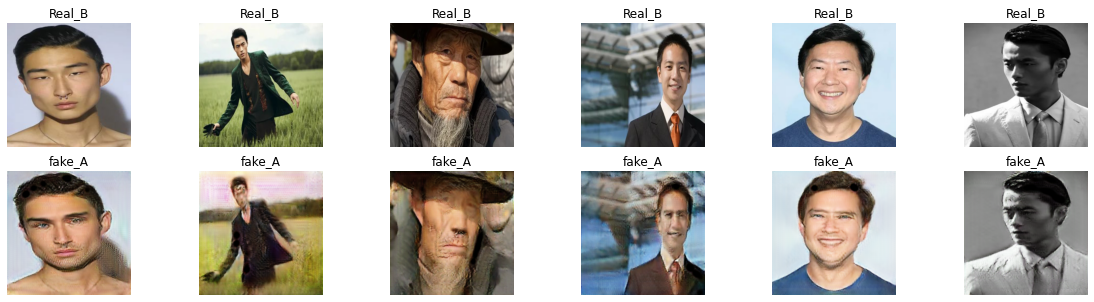

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(20, 5), \
                        sharey=True, sharex=True)
for k in range(6):              
              plt.subplot(2, 6, k+1)
              plt.imshow(for_show(train_dataset[k][0], None))
              plt.title('Real_B')
              plt.axis('off')

              plt.subplot(2, 6, k+7)
              plt.imshow(for_show(fake_A_train[k][0].detach().cpu(), None))
              plt.title('fake_A')
              plt.axis('off')

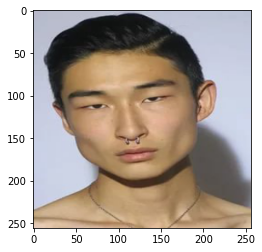

In [ ]:
imshow(train_dataset[0][0])

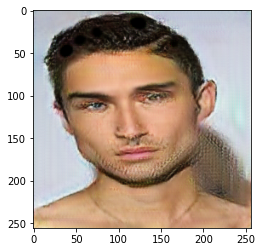

In [ ]:
imshow(fake_A_train[0][0].detach().cpu())

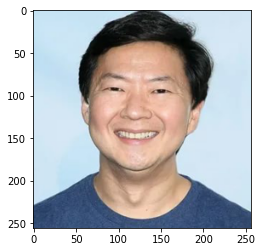

In [ ]:
imshow(train_dataset[4][0])

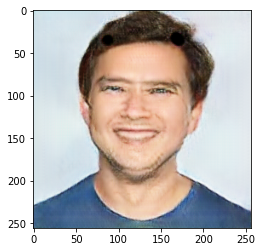

In [ ]:
imshow(fake_A_train[4][0].detach().cpu())

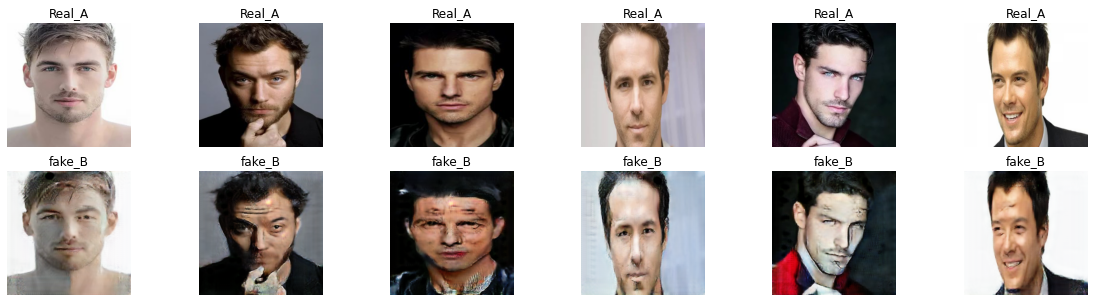

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(20, 5), \
                        sharey=True, sharex=True)
for k in range(6):              
              plt.subplot(2, 6, k+1)
              plt.imshow(for_show(train_dataset[k][1], None))
              plt.title('Real_A')
              plt.axis('off')

              plt.subplot(2, 6, k+7)
              plt.imshow(for_show(fake_B_train[k][0].detach().cpu(), None))
              plt.title('fake_B')
              plt.axis('off')

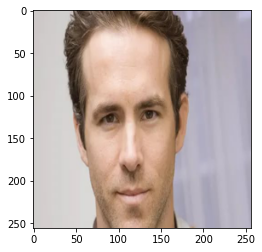

In [ ]:
imshow(train_dataset[3][1])

In [ ]:
imshow(fake_B_train[3][0].detach().cpu())

In [ ]:
imshow(train_dataset[5][1])

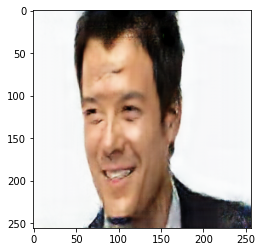

In [ ]:
imshow(fake_B_train[5][0].detach().cpu())

Мы видим, что на трейновом сете модель очень хорошо изменяет лицо и единственной проблемой является наличие артефактов и размытости

# **ВЫВОД**

В своей работе я исследовал возможность превращения лиц людей в другую расу и получил достаточно неплохие результаты. Также я хочу продолжить развивать данный проект (возможно запилить телеграм-бот), улучшить точность модели. Это можно сделать, отобрав более качественный и бОльший датасет, а так же попытаться улучшить архитектуру и поиграться с гиперпараметрами. **CycleGAN - круто!**